Souna Niang

Ousmane Kontao

Oumar Talibe BA


# TP04 MapReduce - Multiplication Matricielle
# Matrice A et B complètes

## Chargement des matrices A et B

In [1]:
import numpy as np
import time
import threading
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
A = np.load("A.npy")
B = np.load("B.npy")

# Affichage des dimensions pour vérification
print(f"Matrice A : {A.shape}")
print(f"Matrice B : {B.shape}")

Matrice A : (100, 10000)
Matrice B : (10000, 100)


In [3]:
%%time
start_time = time.time()
C_numpy = A @ B
stop_time = time.time()
print(f"Temps d'execution : {1000*(stop_time-start_time):.4f} ms")

Temps d'execution : 144.7232 ms
CPU times: user 146 ms, sys: 0 ns, total: 146 ms
Wall time: 145 ms


## Questions

1. Ecrire un algorithme MapReduce qui calcule le produit matriciel de A et B en **multithreading** dans lequel chaque worker réalise le calcul d’un ou plusieurs $c_{ij}$

In [4]:
#TODO
C_thread = np.zeros((A.shape[0], B.shape[1]))
print(f"C : {C_thread.shape}")

C : (100, 100)


In [5]:
def calcule_des_lignes(debut, fin):
    global C_thread
    C_thread[debut:fin, :] = A[debut:fin, :] @ B

In [20]:
temps=[]
for num_threads in range(1,20):
    # %%time
    step = A.shape[0] // num_threads
    threads = []

    start_time = time.time()

    for i in range(num_threads):
        debut, fin = i * step, (i+1) * step
        t = threading.Thread(target=calcule_des_lignes, args=(debut, fin))
        threads.append(t)
        t.start()
        
    for t in threads:
        t.join()

    end_time = time.time()
    temps.append(end_time-start_time)
    #print(f"Temps de Multithreading : {1000*(end_time - start_time):.4f} ms")


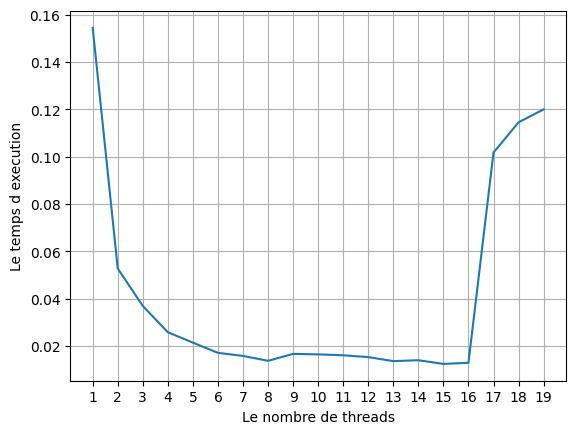

In [22]:
plt.plot([str(i) for i in range(1,20)],temps)
plt.ylabel('Le temps d execution')
plt.xlabel('Le nombre de threads')
plt.grid()

2. Ecrire un algorithme MapReduce qui calcule le produit matriciel de A et B en **mutiprocessing** dans lequel chaque worker réalise le calcul d’un ou plusieurs $c_{ij}$

In [7]:
import multiprocessing

In [ ]:



chunk_types = ["left_chunk", "right_chunk", "both_chunk"]
chunk_type = "left_chunk"

def calcul_chunk(debut, fin, queue):
    if chunk_type == "left_chunk":
        C_partiel = A[debut:fin, :] @ B
    elif chunk_type == "right_chunk":
        C_partiel = A @ B[:, debut:fin]
    elif chunk_type == "both_chunk":
        C_partiel = A[debut:fin, :] @ B[:, debut:fin]
    queue.put((debut, C_partiel))
    
	
num_processes = 4
step = A.shape[0] // num_processes
queue = multiprocessing.Queue()
processes = []

start_time = time.time()

for i in range(num_processes):
	debut, fin = i * step, (i+1) * step
	p = multiprocessing.Process(target=calcul_chunk, args=(debut, fin, queue))
	processes.append(p)
	p.start()

C_mp = np.zeros((A.shape[0], B.shape[1]))

for _ in processes:
	debut, chunk = queue.get()
	if chunk_type == "left_chunk":
		C_mp[debut:debut+chunk.shape[0], :] = chunk
	elif chunk_type == "right_chunk":
		C_mp[:, debut:debut+chunk.shape[1]] = chunk
	elif chunk_type == "both_chunk":
		C_mp[debut:debut+chunk.shape[0], debut:debut+chunk.shape[1]] = chunk

for p in processes:
	p.join()




end_time = time.time()
print(f"Temps de multiprocessing : {1000*(end_time-start_time):.4f} ms")

Temps de multiprocessing : 58.1727 ms


In [10]:
data = {'n': [], 'chunk_type': [], 'time': []}

num_processes = [4, 8, 10, 20, 30, 40]

for n in num_processes:
    for chunk_type in chunk_types:
        step = A.shape[0] // n 
        queue = multiprocessing.Queue()
        processes = []

        start_time = time.time()

        for i in range(n):
            debut, fin = i * step, (i+1) * step
            p = multiprocessing.Process(target=calcul_chunk, args=(debut, fin, queue))
            processes.append(p)
            p.start()

            C_mp = np.zeros((A.shape[0], B.shape[1]))

        for _ in processes:
            debut, chunk = queue.get()
            if chunk_type == "left_chunk":
                C_mp[debut:debut+chunk.shape[0], :] = chunk
            elif chunk_type == "right_chunk":
                C_mp[:, debut:debut+chunk.shape[1]] = chunk
            elif chunk_type == "both_chunk":
                C_mp[debut:debut+chunk.shape[0], debut:debut+chunk.shape[1]] = chunk

        for p in processes:
            p.join()
    
	
        data['n'].append(n)
        data['chunk_type'].append(chunk_type)
        data['time'].append(time.time()-start_time)

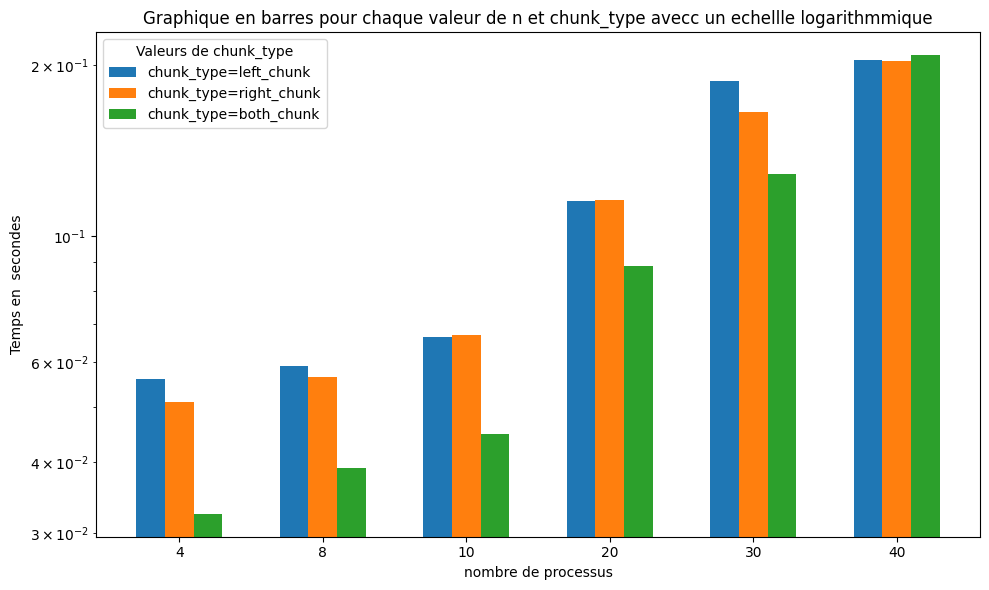

In [ ]:
plt.figure(figsize=(10, 6))
df = pd.DataFrame(data)
# Largeur des barres
bar_width = 0.2

# Positions des barres pour chaque groupe de `n`
positions = np.arange(len(df['n'].unique()))

# Boucle sur les valeurs de `chunk_type` pour tracer les barres
for i, a_value in enumerate(df['chunk_type'].unique()):
    # Filtrer les données pour chaque valeur de `chunk_type`
    subset = df[df['chunk_type'] == a_value]
    # Tracer les barres pour cette valeur de `chunk_type`
    plt.bar(positions + i * bar_width, subset['time'], width=bar_width, label=f'chunk_type={a_value}')

# Ajouter des labels et une légende
plt.xlabel('nombre de processus')
plt.ylabel('Temps en  secondes')
plt.title('Graphique en barres pour chaque valeur de n et chunk_type avecc un echellle logarithmmique')
plt.xticks(positions + bar_width, df['n'].unique())
plt.legend(title='Valeurs de chunk_type')
plt.yscale('log')
# Afficher le graphique
plt.tight_layout()
plt.show()